# Disclaimer

Part of the code in this file is ported or inspired from the CS231N HW3 code:

http://cs231n.github.io/assignments2018/assignment3/

# Keras image generator

In [3]:
from utils.keras_image import ImageDataGenerator

Using TensorFlow backend.


In [4]:
import os
# Use absolute path for root. It will be joined by other relative paths.
ROOT = '/home/minfa/cs231n-fashion'
train_label_to_weight_map_path = os.path.join(ROOT, 'data/train_label_to_weight_map.json')
train_labels_count_to_weight_map_path = os.path.join(ROOT, 'data/train_labels_count_to_weight_map.json')

In [5]:
generator_params = {
    'generator_use_wad': False,
    'generator_use_weight': True,
    'train_label_to_weight_map_path': train_label_to_weight_map_path,
    'train_labels_count_to_weight_map_path': train_labels_count_to_weight_map_path,
}

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True,
    is_training=True,
    params=generator_params)

In [7]:
import json

train_data_dir = '/home/fashion/data/train_processed'
train_label = '/home/fashion/data/train.json'
num_classes = 228
IMG_SIZE = 299
batch_size = 64


def load_labels(json_path):
    labelIds = {}
    with open(json_path, 'r') as f:
        data = json.load(f)
        for label_data in data["annotations"]:
            imgId = label_data["imageId"]
            labelId = [int(x) for x in label_data["labelId"]]
            labelIds[imgId] = labelId
    return labelIds

train_label_map = load_labels(json_path=train_label)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    classes=range(num_classes),
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=batch_size,
                                                    class_mode='multilabel',
                                                    multilabel_classes=train_label_map)

Found 1012935 images belonging to 228 classes.


In [8]:
batches100 = [train_generator.next() for _ in range(100)]

In [9]:
next_batch = batches100[0]
batch_inputs, batch_labels, batch_weights = next_batch

print(batch_inputs.shape)
print(batch_labels.shape)
print(batch_weights.shape)

(64, 299, 299, 3)
(64, 228)
(64,)


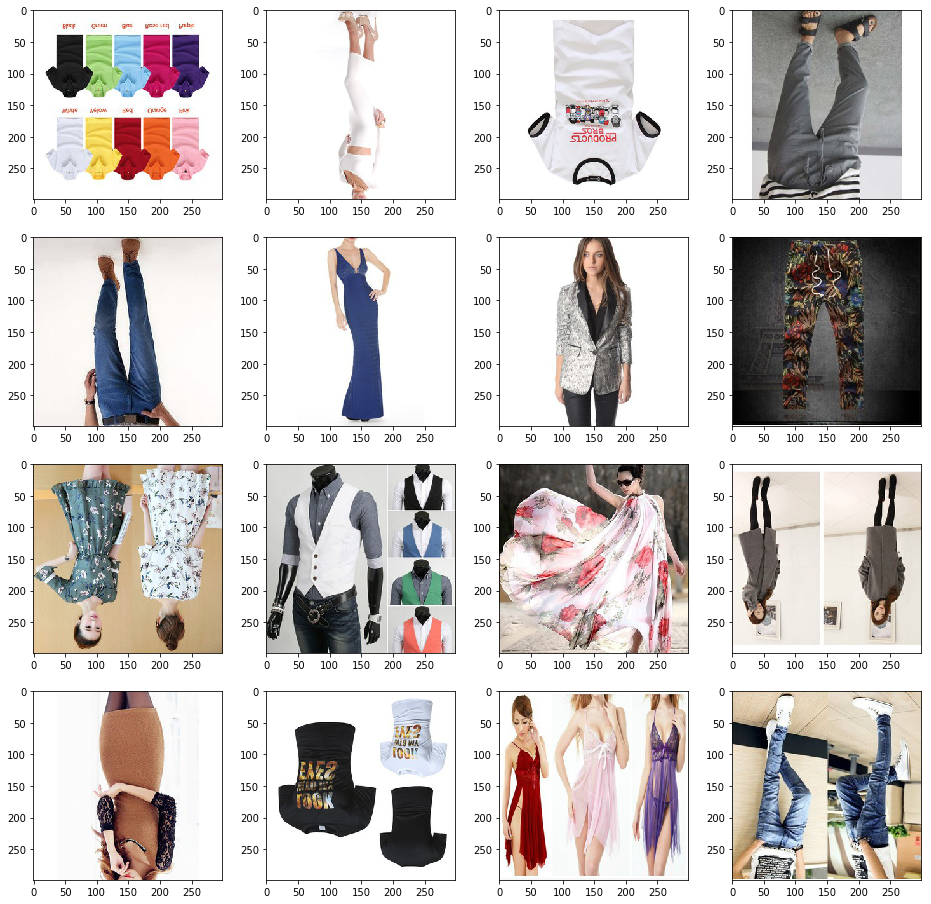

In [10]:
import numpy as np
import matplotlib.pyplot as plt

nrows = 4
ncols = 4

sampled_batch = batches100[np.random.randint(low=0, high=100)]
batch_inputs, batch_labels, batch_weights = sampled_batch

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
batch_sample_indices = np.random.choice(batch_inputs.shape[0], size=nrows*ncols, replace=False)
batch_sample_inputs = batch_inputs[batch_sample_indices]
batch_sample_labels = batch_labels[batch_sample_indices]
assert batch_sample_inputs.shape == (nrows * ncols, 299, 299, 3)

for i in range(nrows):
    for j in range(ncols):
        k = i * ncols + j
        img = batch_sample_inputs[k]
        ax[i, j].imshow(img)

# Saliency maps

A saliency map tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape (H, W, 3) then this gradient will also have shape (H, W, 3); for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape (H, W) and all entries are nonnegative.

In [1]:
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/minfa/.local/share/virtualenvs/cs231n-fashion-rD9JfZw-/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def _compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images, numpy array of shape (N, H, W, 3)
    - y: Labels for X, numpy of shape (N,)
    - model: A model that will be used to compute the saliency map. Must have the following attributes:
        ".score", ".image", "labels".

    Returns:
    - saliency: A numpy array of shape (N, H, W) giving the saliency maps for the
        input images.
    """
    saliency = None
    # Compute the score of the correct class for each example.
    # This gives a Tensor with shape [N], the number of examples.
    #
    # Note: this is equivalent to scores[np.arange(N), y] we used in NumPy
    # for computing vectorized losses.
    correct_scores = tf.gather_nd(model.scores,
                                  tf.stack((tf.range(X.shape[0]), model.labels), axis=1))
    ###############################################################################
    # TODO: Produce the saliency maps over a batch of images.                     #
    #                                                                             #
    # 1) Compute the “loss” using the correct scores tensor provided for you.     #
    #    (We'll combine losses across a batch by summing)                         #
    # 2) Use tf.gradients to compute the gradient of the loss with respect        #
    #    to the image (accessible via model.image).                               #
    # 3) Compute the actual value of the gradient by a call to sess.run().        #
    #    You will need to feed in values for the placeholders model.image and     #
    #    model.labels.                                                            #
    # 4) Finally, process the returned gradient to compute the saliency map.      #
    ###############################################################################
    loss = tf.reduce_sum(correct_scores)
    dimage = tf.gradients(loss, model.image)[0]
    dimage_np = sess.run(dimage, feed_dict={
        model.image: X,
        model.labels: y,
    })  # shape = (N, H, W, 3)
    dimage_abs_np = np.abs(dimage_np)  # shape = (N, H, W, 3)
    saliency = dimage_abs_np.max(axis=3)  # (N, H, W)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency


def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images, numpy array of shape (N, H, W, 3)
    - y: Labels for X, numpy of shape (N, 228)
    - model: A model that will be used to compute the saliency map. Must have the following attributes:
        ".score", ".image", "labels".

    Returns:
    - saliency: list[dict] giving the saliency maps for the
    input images. Each element is a dict whose key to be label_id, and value to be numpy array of shape [H, W].
    """
    saliency_maps = []
    
    for Xi, yi in zip(X, y):
        Xi = np.expand_dims(Xi, 0)  # shape = (1, H, W, 3)
        
        correct_labels = [
            label_id
            for label_id, label_val in enumerate(yi, start=1)
            if label_val == 1
        ]
        
        saliency_map = {}
        
        for label_id in correct_labels:
            label_index = np.array([label_id - 1])  # shape = (1,)
            saliency_map[label_id] = _compute_saliency_map(Xi, label_index, model)
            
    return saliency_maps

label_ids: [49, 66, 105, 168, 200]


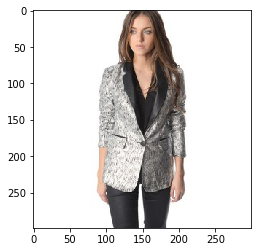

In [16]:
sample_input = batch_sample_inputs[6]
sample_labels = batch_sample_labels[6]
print('label_ids:', [label_id for label_id, val in enumerate(sample_labels, start=1) if val == 1])
plt.imshow(sample_input)